# Partie 4 du document

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import fonctionsAKM
from tqdm import tqdm

In [58]:
#On commence par fixer le nombre de docteurs et le nombre de patients 

#Le nombre de docteurs:
nombre_docteur = 100
#Le nombre de patients:
nombre_patient = 100
#le nombre de clusters:
nombre_cluster =10

Dans le document on nous dit de prendre le modèle suivant :

 $D_{ij}= \mathbb{1}_{\{c + dX_{ij} - \alpha_{i} + \psi_{j} + V_{i,j}>0\}} $

 $Y_{i,j} = a + bX_{i,j} + \alpha_{i} - \psi_{j} + \epsilon_{i,j}$

 On a ici $\epsilon_{i,j} \sim \mathcal{N}(0,1)$ et $V_{i,j} \sim \mathcal{N}(0,1)$

 Pour correspondre au mieux à notre modèle, on va cependant se remettre sur la même base que dans la partie

$D_{i,j} \sim \mathcal{B}(1,\frac{e^{\lambda_{ij}}}{1+e^{\lambda_{ij}}})$ où:

 $\lambda_{ij}= c + dX_{ij} + \alpha_i + \psi_j $


In [59]:
#On s'occupe maintenant de créer les variables de notre modèle
#On se remet dans le même contexte que quand on appliquait AKM
## Ici on reprend donc juste le code de la partie AKM
a = 0
b = 3
c = 0
d = 4

#On commence par déterminer la position des individus sur le plan [0,1]*[0,1]
def position (n):
    return (np.random.uniform(0,1,size = (n)), np.random.uniform(0,1,size = (n)))
position_docteur = position(nombre_docteur)
position_patient = position(nombre_patient)

#On calcule la distance entre eux (notre Xij)
matrice_distance = np.zeros((nombre_patient, nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        matrice_distance[i,j] = np.sqrt((position_patient[1][i]-position_docteur[1][j])**2+(position_patient[0][i]-position_docteur[0][j])**2)

#On crée les alpha_i et psi_j
alpha_d = np.random.randint(0,30,size=nombre_patient)/10
psi_d = np.random.randint(0,30,size=nombre_docteur)/10

alpha_y = np.random.randint(0,3,size=nombre_patient)
psi_y = np.random.randint(0,3,size=nombre_docteur)

#On crée les Dij
lien = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        lambda_ij = c + d*matrice_distance[i,j]-alpha_d[i]+psi_d[j]
        lien[i,j] = np.random.binomial(1,1-(1/(1+np.exp(lambda_ij))))

#On crée ensuite les Yij
prix = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        prix[i,j] = a + b*matrice_distance[i,j] + alpha_d[i] - psi_d[j] + np.random.normal(0,1)#
        #Ici on avait pas mis la normal dans AKM, à discuter

prix_observe = prix*lien

In [60]:
lien.sum()

np.float64(8163.0)

In [61]:
if False:
    plt.figure(figsize=(6, 6))
    plt.scatter(position_docteur[0], position_docteur[1], color='blue', alpha=0.7, label="Docteur")
    plt.scatter(position_patient[0], position_patient[1], color='red', alpha=0.7, label="Patient")
    for i in range(nombre_patient):
        for j in range(nombre_docteur):
            if lien[i,j] == 1:
                plt.plot([position_docteur[0][j], position_patient[0][i]], [position_docteur[1][j], position_patient[1][i]], 'k-',alpha=0.5,color="green")
    plt.title("Points aléatoires uniformes dans [0,1]²")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('square')
    plt.legend()
    plt.show()

In [62]:
#On effectue maintenant la "two-step method"

#Commençons par l'étape de classification
Moment_1_i = lien.sum(axis=1)
Moment_2_i = (prix*lien).sum(axis=1)

Moment_1_j = lien.sum(axis=0)
Moment_2_j = (prix*lien).sum(axis=0)

ecart_type_i = []
for i in range(nombre_patient):
    vecteur_i = []
    for j in range(nombre_docteur):
        if prix_observe[i,j] >0:
            vecteur_i.append(prix_observe[i,j])
    std = np.std(vecteur_i, ddof=1)
    ecart_type_i.append(std)

ecart_type_j = []
for j in range(nombre_docteur):
    vecteur_j = []
    for i in range(nombre_patient):
        if prix_observe[i,j] >0:
            vecteur_j.append(prix_observe[i,j])
    std = np.std(vecteur_j, ddof=1)
    ecart_type_j.append(std)

In [63]:
Moment_1_i_ecart = Moment_1_i/np.array(ecart_type_i)
Moment_2_i_ecart = Moment_2_i/np.array(ecart_type_i)
Moment_1_j_ecart = Moment_1_j/np.array(ecart_type_j)
Moment_2_j_ecart = Moment_2_j/np.array(ecart_type_j)

In [64]:
print(Moment_1_i_ecart,Moment_1_j_ecart)

[ 66.12051179  96.70076501  89.50518446  48.604838   108.71937007
  59.94336229  58.15091913  69.23189857  86.58961838  90.99106757
  56.0900455   93.08149023  42.28079036  43.88846679  56.86813289
  94.9947346   84.66001066  60.81858305  51.98473638  46.81045426
  52.36675074  69.99147392 113.36939053  86.33883813  52.13144492
  46.66733015  69.16382554  57.70278694  76.57572661  59.9443484
  85.79522647  84.59075133  63.01781288  58.66602885  61.68322752
  82.99965781  47.17061144 103.28261476  56.762122    56.81902581
  94.56572986  82.43756227  54.70795626  95.07294537  79.90002348
 121.72580597  51.67501577  91.52249072  62.3191146   50.59734894
  54.48828767  89.75933323 154.62467925  56.11352694  44.48716559
  51.96269378  95.95419949  47.47089996  99.83338409  97.65265888
  55.29926654 111.24790359  52.25978106  56.3424413  109.90203944
  68.87199998 133.41006898  77.0329835  104.49184314  77.31592378
  47.0543388   51.10018219  79.95530085  45.35891127  72.09294207
  77.203581

In [65]:
#Nous allons maintenant classifier les docteurs et les patients
#Nous utilisons k-means

from sklearn.cluster import KMeans
moments_patients = np.array([[Moment_1_i_ecart[i],Moment_2_i_ecart[i]] for i in range(len(Moment_1_i))])
kmeans_patients = KMeans(n_clusters=nombre_cluster)
labels_patients = kmeans_patients.fit_predict(moments_patients)
moments_docteurs = np.array([[Moment_1_j_ecart[j],Moment_2_j_ecart[j]] for j in range(len(Moment_1_j))])
kmeans_docteurs = KMeans(n_clusters=nombre_cluster)
labels_docteurs = kmeans_docteurs.fit_predict(moments_docteurs)

In [66]:
# Nous passons maintenant à la seconde étape de la two-step method

patient_ids = np.repeat(np.arange(nombre_patient), nombre_docteur)
doctor_ids = np.tile(np.arange(nombre_docteur), nombre_patient)

df = pd.DataFrame({
    'patient_id': patient_ids,
    'doctor_id': doctor_ids,
    'distance': matrice_distance.flatten(),
    'link': lien.flatten(),
    'prix': prix.flatten(),
    'prix_observe': prix_observe.flatten()
})

df

,patient_id,doctor_id,distance,link,prix,prix_observe
0,0,0,0.392926,1.0,-0.122414,-0.122414
1,0,1,0.280503,0.0,2.754971,0.000000
2,0,2,0.405550,1.0,-0.425442,-0.425442
3,0,3,0.589856,0.0,5.020580,0.000000
4,0,4,0.339916,0.0,3.284506,0.000000
...,...,...,...,...,...,...
9995,99,95,0.949098,1.0,3.167285,3.167285
9996,99,96,0.917723,1.0,1.206829,1.206829
9997,99,97,0.612434,1.0,1.317030,1.317030
9998,99,98,0.736610,1.0,1.444984,1.444984


In [67]:
patient_ids_petit = np.arange(nombre_patient)
patient_frame = pd.DataFrame({
    'patient_id': patient_ids_petit,
    'kmeans_patients': labels_patients
})

df = pd.merge(df, patient_frame, on='patient_id', how='left')

docteur_ids_petit = np.arange(nombre_docteur)
docteur_frame = pd.DataFrame({
    'doctor_id': docteur_ids_petit,
    'kmeans_doctors': labels_docteurs
})

df = pd.merge(df, docteur_frame, on='doctor_id', how='left')

In [68]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors
0,0,0,0.392926,1.0,-0.122414,-0.122414,6,2
1,0,1,0.280503,0.0,2.754971,0.000000,6,3
2,0,2,0.405550,1.0,-0.425442,-0.425442,6,2
3,0,3,0.589856,0.0,5.020580,0.000000,6,0
4,0,4,0.339916,0.0,3.284506,0.000000,6,3
...,...,...,...,...,...,...,...,...
9995,99,95,0.949098,1.0,3.167285,3.167285,1,0
9996,99,96,0.917723,1.0,1.206829,1.206829,1,5
9997,99,97,0.612434,1.0,1.317030,1.317030,1,4
9998,99,98,0.736610,1.0,1.444984,1.444984,1,4


In [69]:
# On crée des variables dummy pour les clusters obtenus par k-means
df_kmeans_dummies = pd.get_dummies(df['kmeans_patients'], prefix='cluster_patients')

# On ajoute les variables dummy au DataFrame
df = pd.concat([df, df_kmeans_dummies], axis=1)

In [70]:

df_kmeans_dummies = pd.get_dummies(df['kmeans_doctors'], prefix='cluster_doctors')

df = pd.concat([df, df_kmeans_dummies], axis=1)

In [71]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors,cluster_patients_0,cluster_patients_1,...,cluster_doctors_0,cluster_doctors_1,cluster_doctors_2,cluster_doctors_3,cluster_doctors_4,cluster_doctors_5,cluster_doctors_6,cluster_doctors_7,cluster_doctors_8,cluster_doctors_9
0,0,0,0.392926,1.0,-0.122414,-0.122414,6,2,False,False,...,False,False,True,False,False,False,False,False,False,False
1,0,1,0.280503,0.0,2.754971,0.000000,6,3,False,False,...,False,False,False,True,False,False,False,False,False,False
2,0,2,0.405550,1.0,-0.425442,-0.425442,6,2,False,False,...,False,False,True,False,False,False,False,False,False,False
3,0,3,0.589856,0.0,5.020580,0.000000,6,0,False,False,...,True,False,False,False,False,False,False,False,False,False
4,0,4,0.339916,0.0,3.284506,0.000000,6,3,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99,95,0.949098,1.0,3.167285,3.167285,1,0,False,True,...,True,False,False,False,False,False,False,False,False,False
9996,99,96,0.917723,1.0,1.206829,1.206829,1,5,False,True,...,False,False,False,False,False,True,False,False,False,False
9997,99,97,0.612434,1.0,1.317030,1.317030,1,4,False,True,...,False,False,False,False,True,False,False,False,False,False
9998,99,98,0.736610,1.0,1.444984,1.444984,1,4,False,True,...,False,False,False,False,True,False,False,False,False,False


In [72]:
#On effectue les regressions
df_observed = df[df["link"] == 1]
X=pd.concat([df_observed[["distance"]]]+[df_observed[["cluster_patients_"+str(i)]] for i in range(nombre_cluster-1)]+[df_observed[["cluster_doctors_"+str(i)]] for i in range(nombre_cluster-1)], axis=1)
#X = pd.concat([df_observed[["distance"]], df_observed[["cluster_patients_0"]], df_observed[["cluster_patients_1"]], df_observed[["cluster_patients_2"]], df_observed[["cluster_patients_3"]], df_observed[["cluster_doctors_0"]], df_observed[["cluster_doctors_1"]], df_observed[["cluster_doctors_2"]], df_observed[["cluster_doctors_3"]]], axis=1)
X = sm.add_constant(X)
y = df_observed["prix"]
X = X.astype(float)
y = y.astype(float)
model = sm.OLS(y, X)              
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     790.7
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:04:20   Log-Likelihood:                -12239.
No. Observations:                8163   AIC:                         2.452e+04
Df Residuals:                    8143   BIC:                         2.466e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1449      0

In [73]:
#Ici on prend les mêmes alpha_i et psi_j pour les deux trucs, mais je crois que le prof disait qu'il fallait pas faire ça,
# mais j'ai l'impression que le doc fait ça donc à voir à adapter peut être

In [74]:
X_bis=pd.concat([df[["distance"]]]+[df[["cluster_patients_"+str(i)]] for i in range(nombre_cluster-1)]+[df[["cluster_doctors_"+str(i)]] for i in range(nombre_cluster-1)], axis=1)
#X_bis = pd.concat([df[["distance"]], df[["cluster_patients_0"]], df[["cluster_patients_1"]], df[["cluster_patients_2"]], df[["cluster_patients_3"]], df[["cluster_doctors_0"]], df[["cluster_doctors_1"]], df[["cluster_doctors_2"]], df[["cluster_doctors_3"]]], axis=1)
X_bis = sm.add_constant(X_bis)
d = df["link"]
X_bis = X_bis.astype(float)
d = d.astype(float)
logit_model = sm.Logit(d, X_bis)
logit_results = logit_model.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.362255
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   link   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9980
Method:                           MLE   Df Model:                           19
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.2405
Time:                        15:04:20   Log-Likelihood:                -3622.6
converged:                       True   LL-Null:                       -4769.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1978      0.378      0.523      0.601      -0.544       0.939
dista

In [75]:
psi_d

array([2.7, 0.4, 2.8, 0.1, 0. , 2.4, 0.4, 0.1, 1.2, 0.5, 2. , 2.5, 0. ,
       1.7, 1.8, 2.7, 1.4, 0.7, 1.2, 2. , 0.7, 2.3, 2.7, 2.7, 2.2, 0.5,
       0.6, 1.9, 2.5, 2.8, 2.9, 1.4, 2.5, 2.3, 1.2, 2.7, 2.5, 2.1, 1.1,
       1.4, 1.8, 1.1, 1.1, 1.8, 2.3, 0.6, 1.8, 2.9, 1.2, 1.9, 0.3, 0. ,
       1.1, 0.6, 1.7, 1. , 0.3, 2.4, 1.3, 0.9, 2.2, 2.9, 2. , 2.7, 2.3,
       0.7, 2.6, 1. , 1.4, 1. , 2.4, 0.2, 0.2, 1.5, 1.6, 0. , 0.6, 2.2,
       2.8, 0.7, 0.1, 1.6, 0.7, 2. , 0.1, 2.6, 2.6, 2.9, 0.5, 2.1, 2.5,
       0.5, 1.4, 2.9, 0.7, 0.3, 2.3, 1. , 1.6, 1. ])

In [76]:
labels_docteurs

array([2, 3, 2, 0, 3, 1, 0, 0, 3, 3, 4, 8, 0, 7, 7, 8, 1, 3, 4, 1, 0, 2,
       2, 1, 8, 3, 3, 5, 5, 6, 5, 4, 5, 7, 3, 6, 2, 5, 3, 4, 1, 4, 1, 5,
       1, 3, 1, 8, 4, 1, 3, 0, 3, 9, 4, 4, 9, 1, 4, 3, 1, 2, 7, 2, 8, 3,
       5, 0, 1, 3, 5, 3, 3, 3, 4, 3, 0, 5, 6, 0, 3, 4, 3, 1, 0, 2, 8, 2,
       9, 1, 2, 9, 3, 2, 0, 0, 5, 4, 4, 0], dtype=int32)

In [77]:
a=[]
for i in range(nombre_cluster):
    ids=list(df[df['cluster_doctors_'+str(i)]==True]['doctor_id'])
    a.append(np.average([psi_d[i] for i in ids]))
labels_docteurs_average=[a[i] for i in labels_docteurs]


In [78]:
print(np.corrcoef(psi_d, labels_docteurs_average)[0, 1])

0.9278965251086209


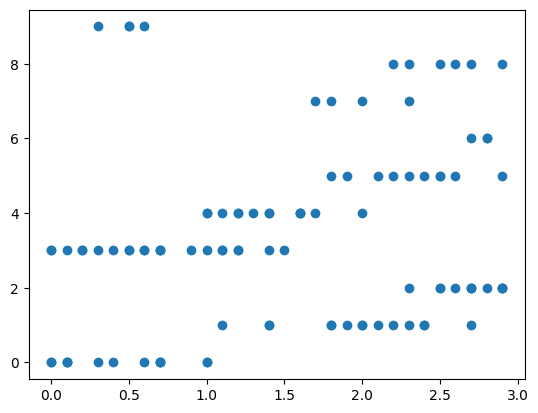

In [79]:
plt.scatter(psi_d, labels_docteurs)

In [80]:
import seaborn as sns

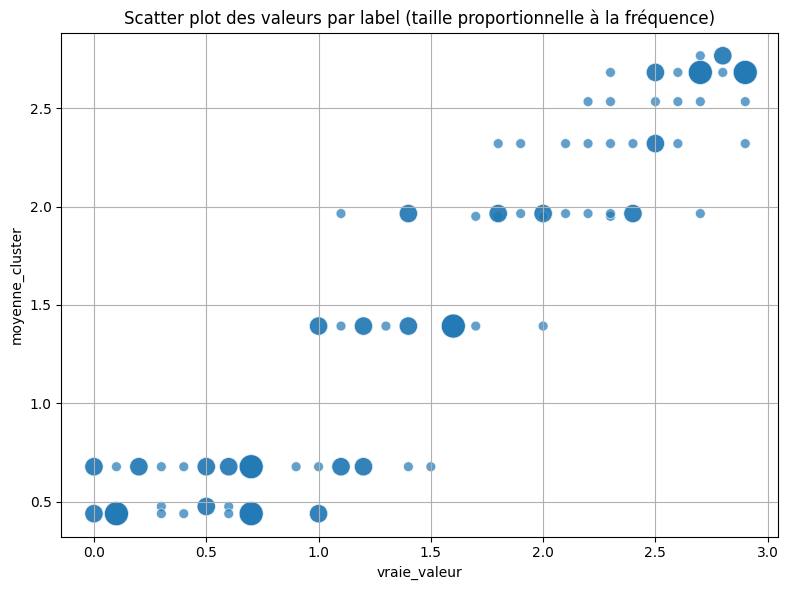

In [81]:
df4 = pd.DataFrame({'vraie_valeur': psi_d, 'moyenne_cluster': labels_docteurs_average})

# 3. Compter les occurrences de chaque (valeur, label)
df4['count'] = df4.groupby(['vraie_valeur', 'moyenne_cluster'])['moyenne_cluster'].transform('count')

# 4. Afficher le scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df4,
    x='vraie_valeur',
    y='moyenne_cluster',
    size='count',        # la taille dépend de la fréquence
    sizes=(50, 300),     # taille minimale et maximale
    legend=False,
    alpha=0.7
)

plt.title('Scatter plot des valeurs par label (taille proportionnelle à la fréquence)')
plt.xlabel('vraie_valeur')
plt.ylabel('moyenne_cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
labels_docteurs

array([2, 3, 2, 0, 3, 1, 0, 0, 3, 3, 4, 8, 0, 7, 7, 8, 1, 3, 4, 1, 0, 2,
       2, 1, 8, 3, 3, 5, 5, 6, 5, 4, 5, 7, 3, 6, 2, 5, 3, 4, 1, 4, 1, 5,
       1, 3, 1, 8, 4, 1, 3, 0, 3, 9, 4, 4, 9, 1, 4, 3, 1, 2, 7, 2, 8, 3,
       5, 0, 1, 3, 5, 3, 3, 3, 4, 3, 0, 5, 6, 0, 3, 4, 3, 1, 0, 2, 8, 2,
       9, 1, 2, 9, 3, 2, 0, 0, 5, 4, 4, 0], dtype=int32)

In [90]:
psi_y

array([1, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2,
       1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 2, 2, 0,
       0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1,
       2, 0, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0])

In [91]:
logit_results.params.iloc[1]

np.float64(3.9913031955288614)

In [92]:
valeurs = [logit_results.params.iloc[1+nombre_cluster+i] for i in range(nombre_cluster-1)]+[0]
valeurs

[np.float64(-0.28058538503195185),
 np.float64(1.129863636118616),
 np.float64(1.9538394438531408),
 np.float64(-0.05715436952019554),
 np.float64(0.8172310711330973),
 np.float64(1.5861163460778744),
 np.float64(2.1830273331909336),
 np.float64(1.3216584776597613),
 np.float64(1.7055948200828197),
 0]

In [93]:
valeurs_clusters= [valeurs[i] for i in labels_docteurs]
valeurs_clusters

[np.float64(1.9538394438531408),
 np.float64(-0.05715436952019554),
 np.float64(1.9538394438531408),
 np.float64(-0.28058538503195185),
 np.float64(-0.05715436952019554),
 np.float64(1.129863636118616),
 np.float64(-0.28058538503195185),
 np.float64(-0.28058538503195185),
 np.float64(-0.05715436952019554),
 np.float64(-0.05715436952019554),
 np.float64(0.8172310711330973),
 np.float64(1.7055948200828197),
 np.float64(-0.28058538503195185),
 np.float64(1.3216584776597613),
 np.float64(1.3216584776597613),
 np.float64(1.7055948200828197),
 np.float64(1.129863636118616),
 np.float64(-0.05715436952019554),
 np.float64(0.8172310711330973),
 np.float64(1.129863636118616),
 np.float64(-0.28058538503195185),
 np.float64(1.9538394438531408),
 np.float64(1.9538394438531408),
 np.float64(1.129863636118616),
 np.float64(1.7055948200828197),
 np.float64(-0.05715436952019554),
 np.float64(-0.05715436952019554),
 np.float64(1.5861163460778744),
 np.float64(1.5861163460778744),
 np.float64(2.183027333

In [94]:
np.corrcoef(valeurs_clusters, psi_d)

array([[1.        , 0.92239991],
       [0.92239991, 1.        ]])

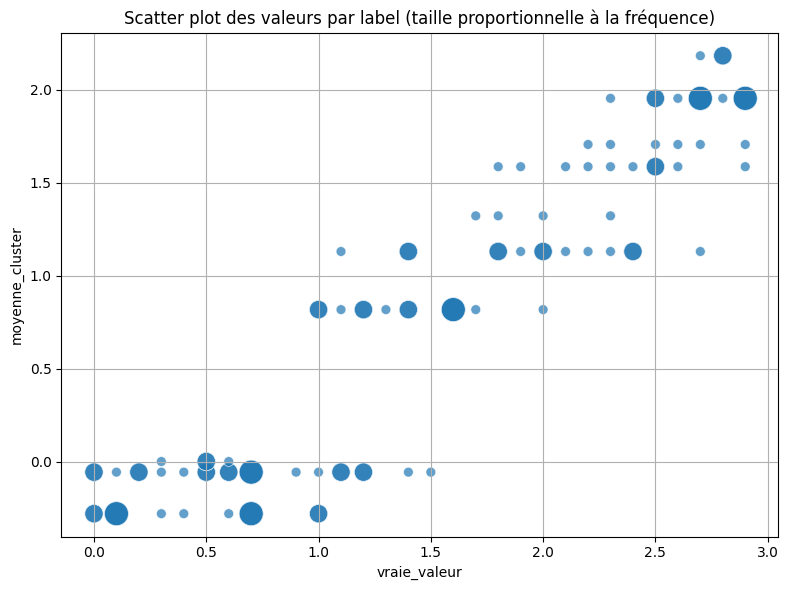

In [95]:
df4 = pd.DataFrame({'vraie_valeur': psi_d, 'moyenne_cluster': valeurs_clusters})

# 3. Compter les occurrences de chaque (valeur, label)
df4['count'] = df4.groupby(['vraie_valeur', 'moyenne_cluster'])['moyenne_cluster'].transform('count')

# 4. Afficher le scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df4,
    x='vraie_valeur',
    y='moyenne_cluster',
    size='count',        # la taille dépend de la fréquence
    sizes=(50, 300),     # taille minimale et maximale
    legend=False,
    alpha=0.7
)

plt.title('Scatter plot des valeurs par label (taille proportionnelle à la fréquence)')
plt.xlabel('vraie_valeur')
plt.ylabel('moyenne_cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
valeurs = [logit_results.params.iloc[1+i] for i in range(nombre_cluster-1)]+[0]
valeurs

[np.float64(3.9913031955288614),
 np.float64(0.31363684762377425),
 np.float64(-0.5282746712376024),
 np.float64(-1.3821595618624316),
 np.float64(-0.03026211918910514),
 np.float64(0.5775167353147996),
 np.float64(-1.9894857778883137),
 np.float64(-1.6461258050578051),
 np.float64(0.2897521333434753),
 0]

In [ ]:
if False:
            a=[]
            b=[]
            for i in range(nombre_cluster):
                docids=list(df[df['cluster_doctors_'+str(i)]==True]['doctor_id'])
                patids=list(df[df['cluster_patients_'+str(i)]==True]['patient_id'])
                a.append(np.average([self.effet_doc[i] for i in docids]))
                b.append(np.average([self.effet_pat[i] for i in patids]))
            labels_docteurs_average=[a[i] for i in labels_docteurs]
            labels_patients_average=[b[i] for i in labels_patients]
            print("corrélation des effets fixes des docteurs avec la moyenne du groupe estimé", np.corrcoef(self.effet_doc, labels_docteurs_average)[0, 1])
            print("corrélation des effets fixes des patients avec la moyenne du groupe estimé",np.corrcoef(self.effet_pat, labels_patients_average)[0, 1])

        

        

        if print_corr:

            dfplot = pd.DataFrame({'vraie_valeur': self.effet_pat, 'moyenne_cluster': labels_patients_average})

            dfplot['count'] = dfplot.groupby(['vraie_valeur', 'moyenne_cluster'])['moyenne_cluster'].transform('count')


            plt.figure(figsize=(8, 6))
            sns.scatterplot(
                data=dfplot,
                x='vraie_valeur',
                y='moyenne_cluster',
                size='count',        # la taille dépend de la fréquence
                sizes=(50, 300),     # taille minimale et maximale
                legend=False,
                alpha=0.7
            )
            plt.plot(self.effet_pat, self.effet_pat, label='y=x', color="red")
            plt.title("Moyenne d'effet fixe du cluster du patient par rapport à leur vraie valeur")
            plt.xlabel('vraie_valeur')
            plt.ylabel('moyenne_cluster')
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()

            dfplot = pd.DataFrame({'vraie_valeur': self.effet_doc, 'moyenne_cluster': labels_docteurs_average})

            dfplot['count'] = dfplot.groupby(['vraie_valeur', 'moyenne_cluster'])['moyenne_cluster'].transform('count')

            plt.figure(figsize=(8, 6))
            sns.scatterplot(
                data=dfplot,
                x='vraie_valeur',
                y='moyenne_cluster',
                size='count',       
                sizes=(50, 300),   
                legend=False,
                alpha=0.7
            )
            plt.plot(self.effet_doc, self.effet_doc, label='y=x', color="red")
            plt.title("Moyenne d'effet fixe du cluster du docteur par rapport à leur vraie valeur")
            plt.xlabel('vraie_valeur')
            plt.ylabel('moyenne_cluster')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()


        return(logit_results, results)





